In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

Generation of the covariance matrix and normalization

In [3]:
#number of features
N = 8

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat = covmat/np.trace(covmat)

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass

eigvals, eigvecs = np.linalg.eig(covmat)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

In [4]:
def select_eigenvalues(eigenvalues_occurrences, bits, n):
    max_val = 1
    relevant_eigvals = []

    for i in range(n):
        eigenvalues_occurrences = [j for j in eigenvalues_occurrences if j[0] <= max_val]
        if len(eigenvalues_occurrences)<=0:
            break
        most_relevant = eigenvalues_occurrences.pop(-1)[0]
        max_val -= most_relevant - (0.5**(bits+1))
        relevant_eigvals.append(most_relevant)
    return relevant_eigvals

In [5]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigvals[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvecs.T[i],4)])} ].")

Eigvector associated to 0.00303: [0.5713,-0.2352,-0.1237,-0.6086,-0.0202,-0.3712,0.3043,-0.0435 ].
Eigvector associated to 0.01558: [0.1624,0.2782,0.1307,0.508,-0.1387,-0.7746,0.0293,0.0304 ].
Eigvector associated to 0.02764: [0.1278,0.7642,-0.4242,-0.157,0.0776,0.1319,0.0882,0.4047 ].
Eigvector associated to 0.04774: [-0.1431,-0.0765,-0.0385,0.1235,-0.7169,0.1746,0.6266,0.1413 ].
Eigvector associated to 0.06851: [-0.1756,-0.5034,-0.4578,0.1425,0.1232,-0.2021,-0.1064,0.6469 ].
Eigvector associated to 0.08586: [0.4708,-0.0899,0.4738,0.2964,0.3451,0.3057,0.2857,0.4047 ].
Eigvector associated to 0.22593: [0.4689,-0.0469,0.0316,0.0277,-0.5593,0.1878,-0.6323,0.1682 ].
Eigvector associated to 0.52571: [0.3716,-0.1171,-0.5925,0.4719,0.1156,0.2114,0.1161,-0.4505 ].


[(0.171875, 1), (0.28125, 1), (0.4375, 1), (0.3125, 1), (0.671875, 1), (0.796875, 1), (0.59375, 1), (0.5625, 1), (0.921875, 1), (0.953125, 1), (0.890625, 2), (0.109375, 3), (0.125, 3), (0.203125, 3), (0.5, 3), (0.96875, 3), (0.546875, 6), (0.984375, 11), (0.21875, 17), (0.515625, 26), (0.0625, 168), (0.078125, 228), (0.53125, 322), (0.0, 346), (0.046875, 382), (0.234375, 400), (0.09375, 418), (0.015625, 424), (0.03125, 425)]
[0.03125, 0.015625, 0.09375, 0.234375, 0.046875, 0.0, 0.53125, 0.078125]
Using estimate for 0.03125: [ 0.17407766  0.78495963 -0.40201513 -0.10050378  0.10050378  0.20100756
  0.          0.36237154], with weight: 0.030303030303030304
Using estimate for 0.015625: [ 0.18411492  0.27617239  0.1594482   0.54461929 -0.         -0.74787836
  0.09205746 -0.        ], with weight: 0.015151515151515152
Using estimate for 0.09375: [ 0.42857143 -0.14285714  0.47380354  0.26726124  0.3350297   0.30304576
  0.34992711  0.41649656], with weight: 0.09090909090909091
Using estima

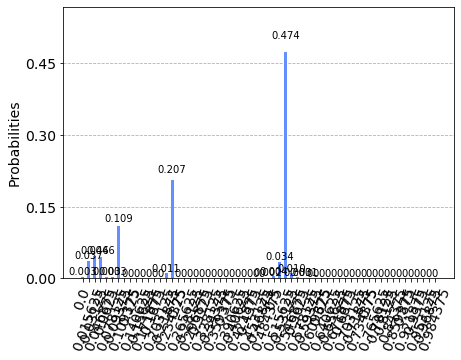

In [6]:
bits = 8
shots_per_vec1 = 100
shots_per_vec2 = 1000
roundoff = 2

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
eigval_occurences = res.get_eigvals()
print(eigval_occurences)

#THRESHOLDING

relevant_eigvals = select_eigenvalues(eigval_occurences, bits-roundoff, N)
print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]

result = None
for ev,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(ev)
    print(f"Using estimate for {ev}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff))

plot_histogram(result.get_eigvals(False))

In [8]:
K = 4

#RETRIEVE EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(select_eigenvalues(result.get_eigvals(), bits-roundoff, N))
estimated_eigvals = [i for i in estimated_eigenvalues[-K:]]
print("eigenvalues considered ", estimated_eigvals)
eigenvectors = [result.eigvec_from_eigval(i) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)
lowrank_covmat = np.matmul(np.matmul(eigvecs[:,-K:],np.diag(eigvals[-K:])),eigvecs[:,-K:].T)
diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

#VECTORS ORTHOGONALITY
U = np.matmul(estimated_eigvecs.T, estimated_eigvecs)
print("vectors orthogonality error ",np.linalg.norm(U - np.eye(K))/K)

eigenvalues considered  [0.09375, 0.203125, 0.21875, 0.375]
reconstruction error l2 norm  0.61056150237095
vectors orthogonality error  0.16531410019220183


In [18]:
print("eigenvalues: ",estimated_eigvals)
err = 0
for i in range(K):
    v1 = result.eigvec_from_eigval(estimated_eigvals[-i-1])
    v2 = eigvecs[:,-i-1]
    d1 = np.linalg.norm(v1-v2)
    d2 = np.linalg.norm(v2+v1)
    err += d1 if d1 < d2 else d2
err /= K
print("average eigenvector error l2 norm: ",err)

eigenvalues:  [0.109375, 0.140625, 0.15625, 0.46875]
average eigenvector error l2 norm:  0.3538375884014342


In [ ]:
print(covmat)